# Question 1
Generate and plot a test dataset

In [1]:
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt

np.random.seed(0) # Set a defined random seed


Set it to
produce two features in your dataset, of which two are informative and zero redundant, with 100
samples. Please note that you need to follow these exact numbers otherwise you will end up with a
different distribution and other parts of the tutorial won’t work. Note that there are two outputs: X
is a matrix containing the samples themselves, and y is a vector giving a label for each sample in the
X vector.

In [2]:
X,y = datasets.make_classification(n_samples = 100, n_features = 2, n_informative = 2, n_redundant = 0)

This creates a dataset of 100 samples - each sample has 2 features both of which are informative (i.e. they have something to do with the classification) - the output is a matrix with a column for each feature and a row for each sample. y is the label (1 or 0) for those to be classified into.

In [3]:
print(X[0:5,:])
print(y[0:5])

[[-0.76605469  0.18332468]
 [-0.92038325 -0.0723168 ]
 [-0.98658509 -0.28692   ]
 [ 1.70910242 -1.10453952]
 [ 1.9876467   1.77624479]]
[0 0 0 1 1]


THe features are centred on a standard normal dist ish. We want to attribute some meaning to these so lets scale them.


1.   We want the first feature to be defect length in mm, so we want to halve the standard deviation and shift it to be centred at 5mm.
2.   The second one will be in brightness (out of 256 colours) so we scale up by 30 and add a mean of 160.


 This effectively means that the first column is multiplied by 0.5 then 5 is added, and the second
is multiplied by 30 and has 160 added. We will also take the absolute to avoid unphysical negative
numbers appearing.

In [4]:
X[:,0] =np.abs((X[:,0] / 2) + 5)
X[:,1] =np.abs((X[:,0] * 30) + 160)

Using matplotlib, generate a scatter plot, using the classification vector y to set the colour of the
points in each set.

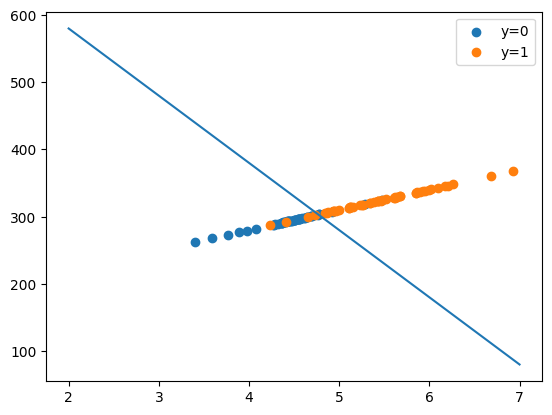

In [5]:
fig, ax = plt.subplots()

# Plot the two features against each other where y = 0
ax.scatter(X[y == 0 , 0],X[y == 0 , 1], label = 'y=0')

# Plot the two features against each other where y = 1
ax.scatter(X[y == 1 , 0],X[y == 1 , 1], label = 'y=1')
plt.legend()

# Now we can see see all points plotted with feature 1 on the x-axis and feature 2 on the y-axis. The colour corresponds ot the ground truth clasification label

# Create a manual decision boundary
x1 = np.linspace(2,7,100)
x2 = -100*x1 + 780 # Equation given in tutorial

plt.plot(x1,x2)
plt.show()

# Question 2
Make a function to generate a suitable covariance matrix

In [14]:
def get_cov(sdx=1., sdy=1., rotangdeg=0.):
    covar = np.array([[sdx**2, 0], [0, sdy**2]]) # define the covariance matrix
    rot_ang = rotangdeg / 360 * 2 * np.pi # convert degrees to radians
    rot_mat = np.array([[np.cos(rot_ang), -np.sin(rot_ang)] , [np.sin(rot_ang), np.cos(rot_ang)]]) # define the standard rotation matrix
    covar = np.matmul(np.matmul(rot_mat, covar), rot_mat.T) # Matrix multiplication (rotation matrix by covariance matrix) by transposed rotation matrix
    return covar




Note that to rotate a matrix **A** to **A**
′ with a rotation matrix R we are using the form
**A**
′ **= RAR^T**
; this is a fairly standard mathematical approach. You can find more online or it is
probably covered elsewhere on your degree

Some background, in case you are interested: while generating the on-diagonal terms of a covariance
matrix is generally straightforward, since these relate easily to the standard deviation, it is not so
easy to do the same for the off-diagonal, covariance terms. Their values have to lie in certain ranges.
Therefore we instead choose this approach - define a matrix with independent parameters x1 and x2
then rotate the distribution, such that we get some dependency between the values (assuming that
the variance is different in each direction).

The below is the distribution function where sigma is the covariance matrix and d is the number of dimensions (features)

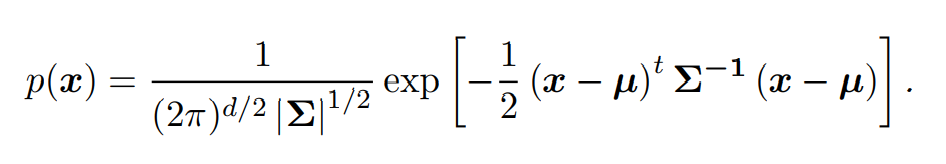

We will calculate the density function on a 200 by 200 grid

In [7]:
x1line = np.linspace(-1, 1, 200)
x2line = np.linspace(-1, 1, 200)

In order to calculate the function on each node we can use meshgrid to generate a grid of a combination of all of hte x1 and x2 values

In [8]:
x1grid, x2grid = np.meshgrid(x1line, x2line) # Gives 2 vectors each of size (1, 200, 200)
# Combine the two into a single vector of size (2, 200, 200) and reshape into (2, 40000)
Xgrid = np.array([x1grid, x2grid]).reshape([2,40000]).T



In [10]:
Xgrid

array([[-1.        , -1.        ],
       [-0.98994975, -1.        ],
       [-0.9798995 , -1.        ],
       ...,
       [ 0.9798995 ,  1.        ],
       [ 0.98994975,  1.        ],
       [ 1.        ,  1.        ]])

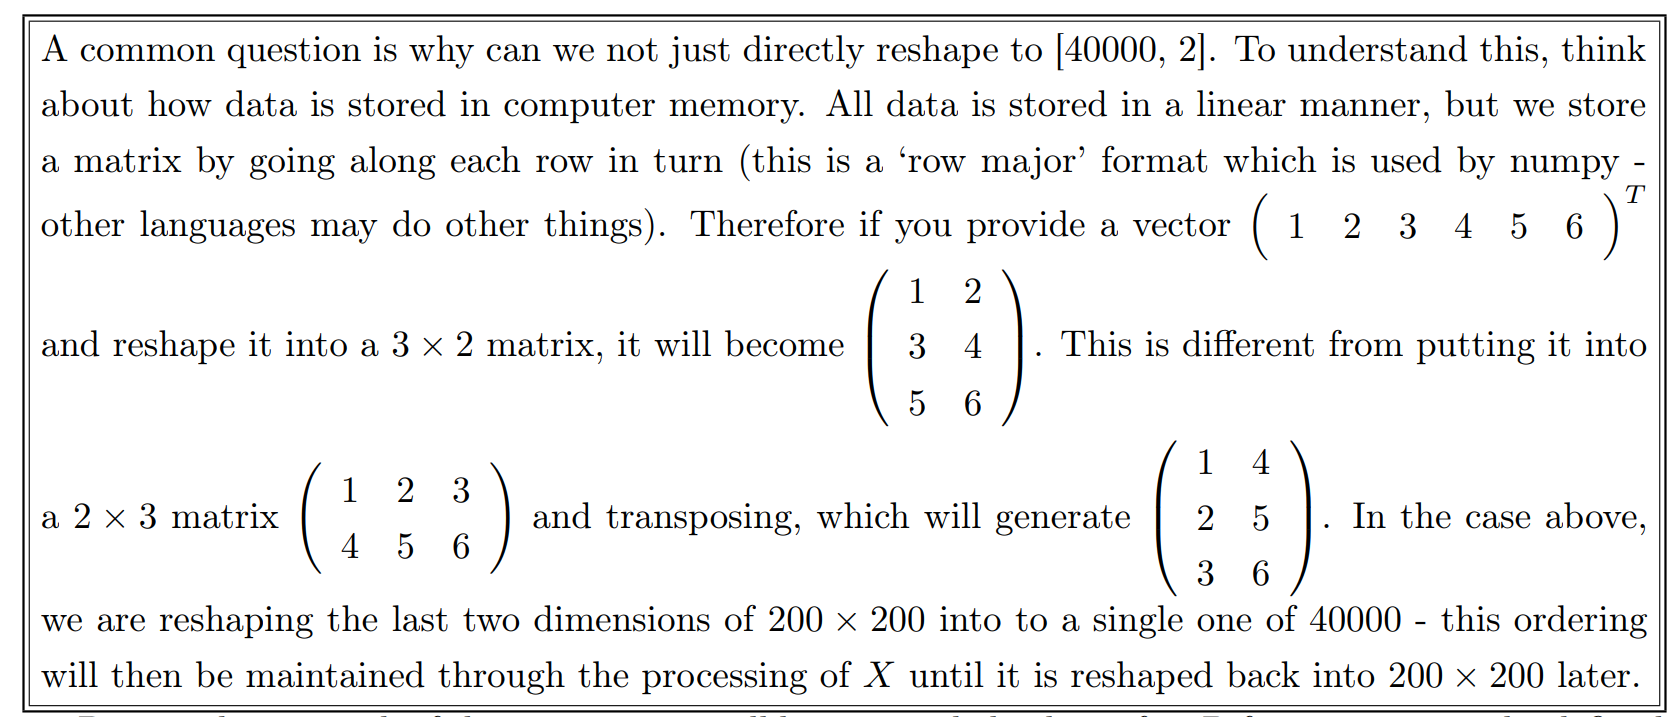

In [11]:
def gen_sample_grid(npx=200, npy=200, limit=1): # This function just creates a meshgrid sampling matrix like we did manually before
  x1line = np.linspace(-limit, limit, npx)
  x2line = np.linspace(-limit, limit, npy)
  x1grid, x2grid = np.meshgrid(x1line, x2line)
  Xgrid = np.array([x1grid, x2grid]).reshape([2,npx*npy]).T
  return Xgrid,x1line,x2line

Produce a covariance matrix of standard deviation 1 in x and 0.3 in y, then rotated around 30
degrees, using the function from earlier.

In [18]:
covMat = get_cov(sdx=1, sdy=0.3, rotangdeg=30)
print(covMat)

[[0.7725     0.39404156]
 [0.39404156 0.3175    ]]


Now, to calculate the probability density function on every point of the meshgrid we could loop over the points - slow.
Rather use matrix multiplication.

In [ ]:
np.linalg.inv(covMat) # Gives inverse of covariance matrix

We're only interested in the distribution, not mean so we let the mean be 0.
For a single point x we could do 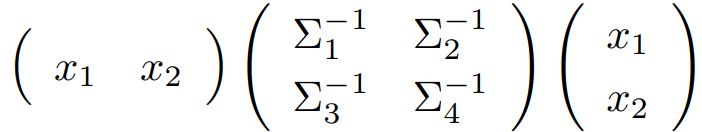

But we want to retain an extra dimension... See tutorial notes for extra details. At the end we can use the function below to calculate the pdf on every point of the meshgrid, and get a 40000 length vector out:

In [19]:
p = 1 / (2 * np.pi * np.sqrt(np.linalg.det(covMat))) * np.exp(
    -1 / 2 * (np.matmul(Xgrid, np.linalg.inv(covMat)) * Xgrid).sum(-1))

In [22]:
p = p.reshape(200,200) # Back to 200 x 200 grid

Plot using contourf

In [31]:
x1grid.ndim

2

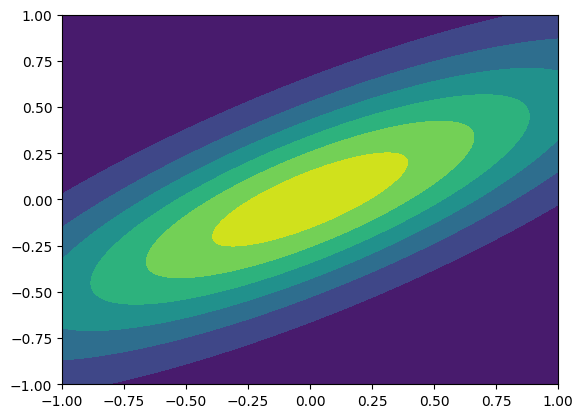

In [37]:
fig, ax = plt.subplots()

plt.contourf(x1grid,x2grid, p)

Then use np.random.multivariate_normal to generate 100 values from this distribution and plot
these on a separate figure (use a mean of 0 for each dimension, i.e. you will need to pass a vector of
two zeros, and size can just be set to 100).

In [58]:
randVals = np.random.multivariate_normal(mean = [0,0], cov = covMat, size = 250)

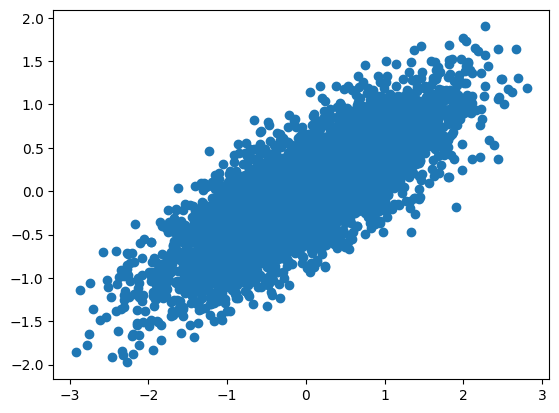

In [57]:
# Plot the values on a separate figure
fig, ax = plt.subplots()

# Plot the two features against each other where y = 0
ax.scatter(randVals[:,0],randVals[:,1])

plt.show()

Now copare whether it the distribution is well represented

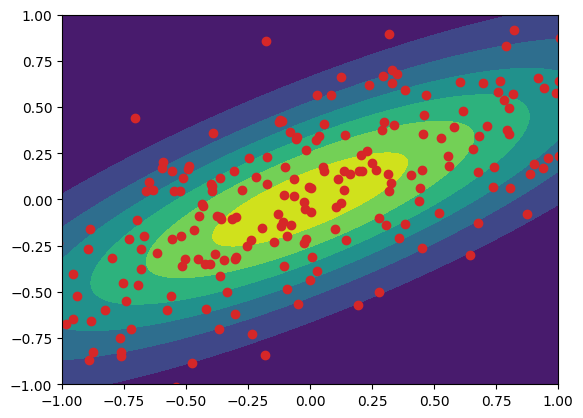

In [59]:
fig, ax = plt.subplots()

plt.contourf(x1grid,x2grid, p)
# Plot the two features against each other where y = 0
ax.scatter(randVals[:,0],randVals[:,1], c = '#d62728')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.show()

# Question 3
Generate a circular distribution